## Part 1: Bellman Ford Algorithm

Implementation Bellman-Ford Algorithm

In [10]:
def bellman(veritices, edges, start):

  # 1. Initialize distances
  distances = { vertex: float('inf') for vertex in veritices}
  predecessor = { vertex: None for vertex in veritices }
  distances[start] = 0

  # 2. Relax edges for n - 1 steps
  for i in range(len(veritices) - 1):
    for u, v, w in edges:
      if distances[u] + w < distances[v]:
        distances[v] = distances[u] + w
        predecessor = [u]

  # 3. Detect negative cycle
  for u, v, w in edges:
    if distances[u] + w < distances[v]:
      print("Negative cycle detected")
      return None
  return distances
  

# vertices=[1,2,3,4,5,6,7], edges=[(u, v, weight),...], start=1, expected={1:0, 2: 1, ... 7: 3} 
tests = [
  (
    [1,2,3,4,5,6,7], #VERTICES
    [(1,2,6), (1,3,5), (1,4,5), (2,5,-1), (3,2,-2), (3,5,1), (4,3,-2), (4,6,-1), (5,7,3), (6,7,3)], #EDGES 
    1, #START_VERTEX
    {1: 0, 2: 1, 3: 3, 4: 5, 5: 0, 6: 4, 7: 3}  #RESULT
  ),
  (
    [1,2,3,4], #VERTICES
    [(3,2,-10),(4,3,3), (1,4,5), (1,2,4)], #EDGES 
    1,  #START_VERTEX
    {1: 0,2: -2, 3: 8, 4: 5} #RESULT
  ),
  # has negative weight cycle
  (
    [1,2,3,4], #VERTICES
    [(3,2,-10), (4,3,3), (1,4,5), (1,2,4), (2,4, 5)],  #EDGES 
    1, #START_VERTEX
    None  #RESULT
  ), 
  # has negative weight cycle
  (
    [0,1,2,3,4,5,6,7,8,9], #VERTICES
    [
      (0,1,5), (1,2,20), (1,5,30), (1,6,60), (2,3,10), (2,4,75), (3,2,-15), (4,9,100), (5,4,25), (5,6,5), (5,8,50), (6,7,-50), (7,8,-10)
    ],
    0, #START_VERTEX
    None,
  ),
  # has negative weight cycle
  (
    ['s', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], #VERTICES
    [
      ('s','a',3), ('s','c',5), ('s','e',2), ('a','b',-4), ('b','g',4), ('c','d',6), ('d','c',-3), ('d','g',8), ('e','f',3), ('f','e',-6), ('f','g',7), ('h','i',2), ('i','j',3), ('j','h',-8), 
    ], #EDGES 
    's', #START_VERTEX
    None
  )
]

print(f"{'*' * 10} Tests {'*' * 10}")
for test in tests:
  vertices = test[0]
  edges = test[1]
  start = test[2]
  expected = test[3]
  actual = bellman(vertices, edges, start)

  passed = "❌"
  if actual == expected: passed = "✅"

  print(f"{passed} {expected == actual}")

********** Tests **********
✅ True
✅ True
Negative cycle detected
✅ True
Negative cycle detected
✅ True
Negative cycle detected
✅ True


## Part 2: Building DeFi Graph

### 2.0 Uniswap V3 Protocol

Build Defi graph with data from:
- TheGraphql
- https://thegraph.com/explorer/subgraphs/5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV
```

In [11]:
import requests
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("api_key")
base_url = "https://gateway.thegraph.com/api"
# ETH-mainnet 
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV" # Uniswap V3
# subgraph_id = "A3Np3RQbaBA6oKJgiwDJeo5T3zrYfGHPWFYayMwtNDum" # Uniswap V2

# BASE-mainnet
# subgraph_id = "GqzP4Xaehti8KSfQmv3ZctFSjnSUYZ4En5NRsiTbvZpz" #  Uniswap V3

subgraph_url = f"{base_url}/subgraphs/id/{subgraph_id}"


### 2.1 Build query thegraph query payload

<!-- ```json
{
  pools(orderBy: volumeUSD, orderDirection: desc, first: 4) {
    token0 {
      name
      symbol
      decimals
    }
    token0Price
    token1Price
    token1 {
      decimals
      name
      symbol
    }
  }
}
``` -->

In [12]:
headers = {
  'Content-Type': 'application/json',
  'Authorization': f'Bearer {api_key}'
}

# Prepare the request payload
payload = {"query": "{ pools (orderBy: volumeUSD, orderDirection: desc, first: 25) { token0 { name symbol decimals id } token0Price token1Price token1 { decimals name symbol id } feeTier id } }"} # V3

# Send the GraphQL request to the Subgraph
response = requests.post(subgraph_url, headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
  data = response.json()['data']['pools']
else:
  print("Error:", response.text)

In [13]:
from defigraph.Graph import Graph
from defigraph.Edge import Edge
from defigraph.Vertex import Vertex
from defigraph.Pool import Pool
from web3 import Web3

edges = []

for pool in data:
  fee = pool['feeTier']  

  token0 = pool['token0']['symbol']
  token0_decimals = int(pool['token0']['decimals'])
  token0_address = Web3.to_checksum_address(pool['token0']['id'])
  token0Price = float(pool['token0Price'])

  token1 = pool['token1']['symbol']
  token1_decimals = int(pool['token1']['decimals'])
  token1_address = Web3.to_checksum_address(pool['token1']['id'])
  token1Price = float(pool['token1Price'])

  pool_address = Web3.to_checksum_address(pool['id'])

  u = Vertex(token0, token0_decimals, token0_address)
  v = Vertex(token1, token1_decimals, token1_address)

  pool = Pool(pool_address=pool_address, token0=u, token1=v, fee=fee, token0_price=token0Price, token1_price=token1Price)
  pool2 = Pool(pool_address=pool_address, token0=v, token1=u, fee=fee, token0_price=token1Price, token1_price=token0Price)
  edge = Edge(pool=pool)
  edge2 = Edge(pool=pool2)
  edges.append(edge)
  edges.append(edge2)

g = Graph(edges=edges)

In [14]:
def bellman_ford(graph: Graph, start_vertex: Vertex):
  distances = {key: float('inf') for key in graph.vertices}
  predecessor = {key: None for key in graph.vertices}

  distances[start_vertex] = 0

  for i in range(len(graph.vertices) - 1):
    for edge in g.get_edges():
      (u,v,w) = edge
      if distances[v] > distances[u] + w[0]:
        distances[v] = distances[u] + w[0]
        predecessor[v] = (u, w) 

  for edge in g.get_edges():
    (u,v,w) = edge
    cycle = [v]
    if distances[v] > distances[u] + w[0]:
      curr = [u]
      print("🌟 CYCLE FOUND", w)


  return distances, predecessor
bellman_ford(g, Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")))

🌟 CYCLE FOUND (0.0009839188497358423, (USDC, USDT, '100'))
🌟 CYCLE FOUND (-7.843967365030478, (USDC, WETH, '3000'))
🌟 CYCLE FOUND (-4.581926387976768e-06, (USDC, DAI, '100'))
🌟 CYCLE FOUND (0.0007870208087857907, (USDC, USDT, '500'))
🌟 CYCLE FOUND (0.0001556560827242494, (USDC, DAI, '500'))
🌟 CYCLE FOUND (0.00012889774414166774, (USDC, FEI, '500'))
🌟 CYCLE FOUND (5.306333755888344, (USDC, HEX, '3000'))
🌟 CYCLE FOUND (-11.116002902853719, (USDC, WBTC, '500'))
🌟 CYCLE FOUND (7.84266903689514, (WETH, USDC, '500'))
🌟 CYCLE FOUND (7.843726889296063, (WETH, USDT, '500'))
🌟 CYCLE FOUND (-3.272453810888543, (WETH, WBTC, '500'))
🌟 CYCLE FOUND (7.843667530619852, (WETH, DAI, '500'))
🌟 CYCLE FOUND (7.8438709311859816, (WETH, USDT, '100'))
🌟 CYCLE FOUND (-3.2741937844220854, (WETH, WBTC, '3000'))
🌟 CYCLE FOUND (-0.16751862985204433, (WETH, wstETH, '100'))
🌟 CYCLE FOUND (7.843962824219048, (WETH, DAI, '3000'))
🌟 CYCLE FOUND (7.842819862162308, (WETH, USDC, '100'))
🌟 CYCLE FOUND (5.400368769480874, 

({USDC: 7.808196730559255,
  WETH: -0.035500454353169175,
  USDT: 7.8107078420918565,
  WBTC: -3.3072128316262916,
  DAI: 7.810648483415646,
  wstETH: -0.20053767705625056,
  LINK: 5.367349722276668,
  USDe: 7.809536544763222,
  APE: 7.657929609948706,
  UNI: 5.727932896932379,
  LOOKS: 10.952139622970286,
  FEI: 7.811077215570413,
  HEX: 13.117282073714616,
  PEPE: 19.325266170228428},
 {USDC: (WBTC, (11.115409562185546, (WBTC, USDC, '3000'))),
  WETH: (USDT, (-7.846208296445026, (USDT, WETH, '3000'))),
  USDT: (WETH, (7.843726889296063, (WETH, USDT, '500'))),
  WBTC: (WETH, (-3.2741937844220854, (WETH, WBTC, '3000'))),
  DAI: (WETH, (7.843667530619852, (WETH, DAI, '500'))),
  wstETH: (WETH, (-0.16751862985204433, (WETH, wstETH, '100'))),
  LINK: (WETH, (5.400368769480874, (WETH, LINK, '3000'))),
  USDe: (USDT, (-0.001171297328635023, (USDT, USDe, '100'))),
  APE: (WETH, (7.690948657152912, (WETH, APE, '3000'))),
  UNI: (WETH, (5.760951944136585, (WETH, UNI, '3000'))),
  LOOKS: (WETH,

## 2.2 Build DeFi Graph

In [15]:
from collections import deque
import math
  
def generate_nodes(data):
  """Take Uniswapv3 raw data and builds an adjacency list graph
  """
  graph = {}
  for pool in data:
    feeTier = pool['feeTier']
    
    token0 = pool['token0']['symbol']
    token0Price = float(pool['token0Price'])

    token1 = pool['token1']['symbol']
    token1Price = float(pool['token1Price'])

    if token0 not in graph: 
      graph[token0] = { feeTier: {token1 : token1Price}}
    else:
      if feeTier not in graph[token0]:
        graph[token0][feeTier] = {token1 : token1Price}
      else:
        graph[token0][feeTier][token1] = token1Price
    if token1 not in graph: 
      graph[token1] = { feeTier: {token0: token0Price }}
    else:
      if feeTier not in graph[token1]:
        graph[token1][feeTier] = { token0: token0Price}
      else:
        graph[token1][feeTier][token0] = token0Price
  return graph

def generate_edges(graph):
  """Takes an adjacency list graph and returns all possible edges
    args:
      graph: { USDC: { pools }, ... , WETH : { pools } }
    returns:
      edges: [(u, v, w), ... ,(u, v, w)]
  """
  edges = []
  # same pool fee edges
  for u in graph:
    q = deque(graph[u].items())
    while q:
      f, vw = q.popleft()
      f = round(float(f) / 10000, 2)
      for v, w in vw.items():
        weight = round(-math.log(w), 4)
        edge = (f"{u} {f}%",f"{v} {f}%", weight)
        if edge not in edges: edges.append(edge)
        for i in range(len(q)):
          f2, vw2 = q[i]
          f2 = round(float(f2) / 10000, 2)
          for v2, w2 in vw2.items():
            weight2 = round(-math.log(w2),4)
            edge2 = (f"{u} {f}%",f"{v2} {f2}%",weight2)
            if edge2 not in edges: edges.append(edge2)
  return edges

N = generate_nodes(data)
E = generate_edges(N)
V = list(set([v[0] for v in E]))

print(f"No. of Edges {len(E)}")
print(f"No. of Vertices {len(V)}")

No. of Edges 84
No. of Vertices 23


### 2.3 Visualize our graph and detect negative cycles

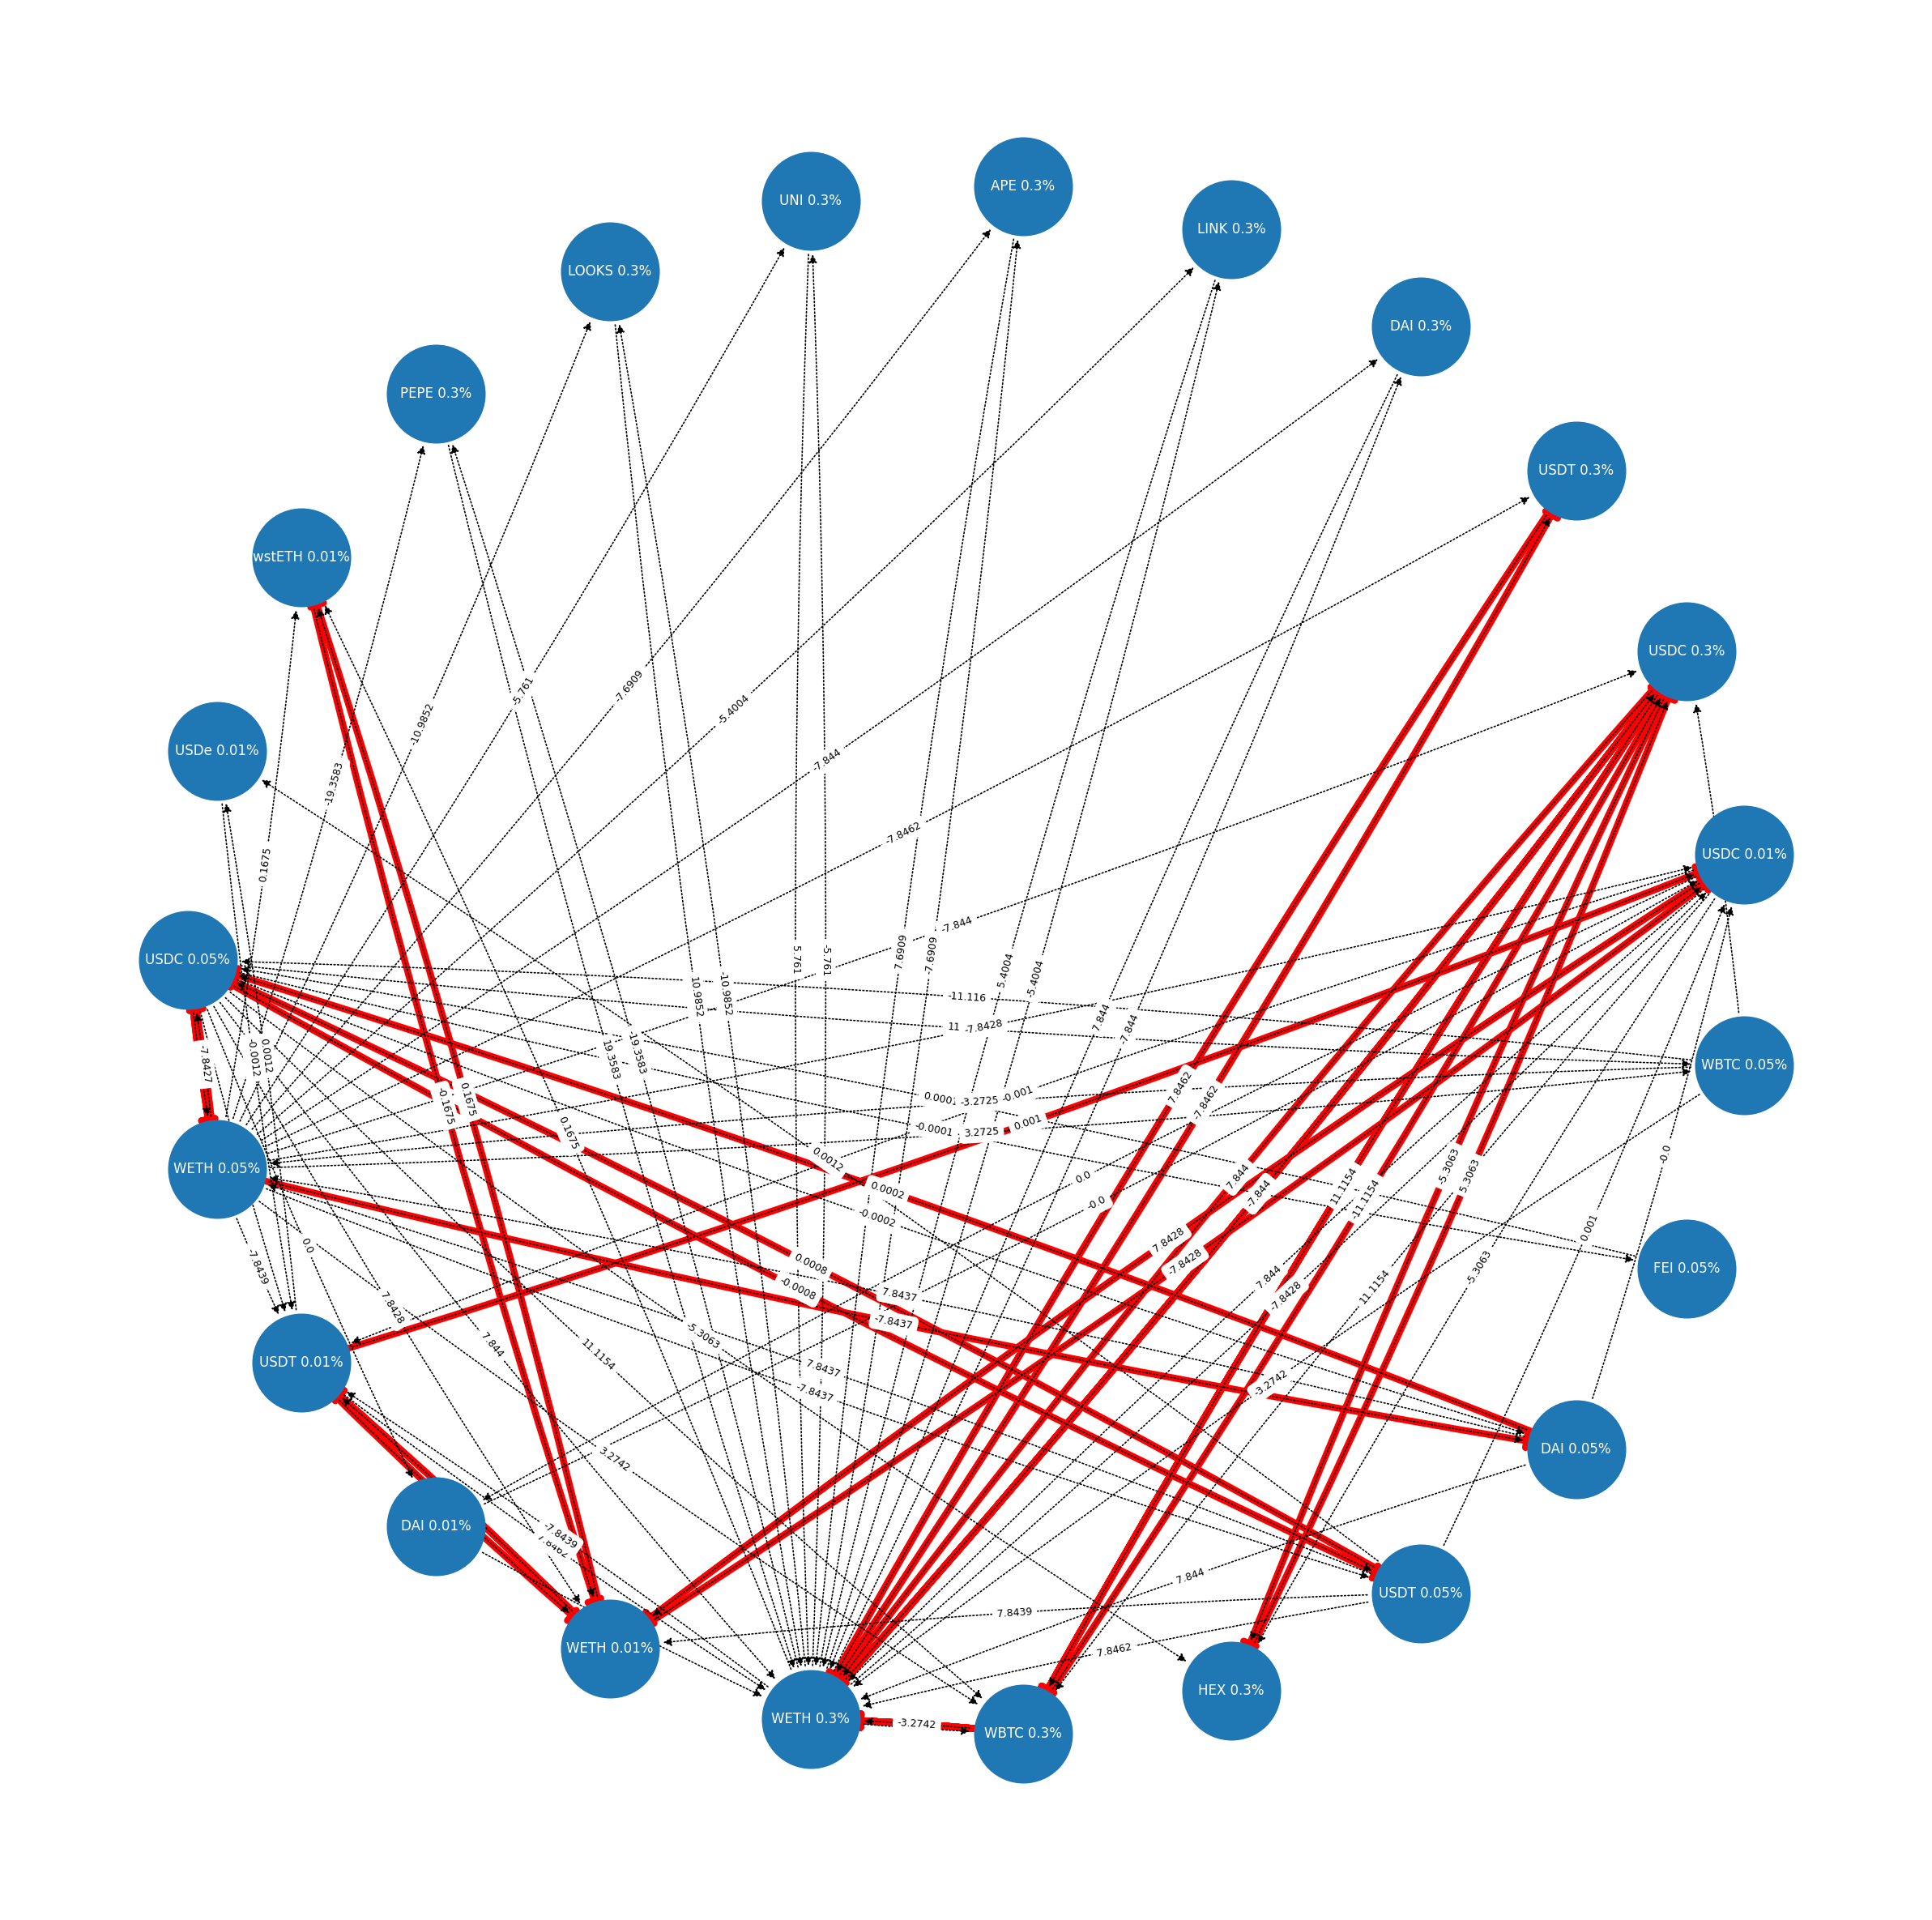

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
G.add_weighted_edges_from(E)
plt.figure(3, figsize=(10, 10), dpi=300)

pos = nx.shell_layout(G) 
# C = nx.Graph([('WETH-500', 'USDT-500'), ('USDT-500','USDC-500')])

all_cycles = []

def search_for_pool(origin, dest, feeTier):
  pools = data
  for pool in pools:
    fee = pool['feeTier']
    if fee == feeTier:
      token1 = pool['token1']['symbol']
      token0 = pool['token0']['symbol']
      if (token1 == origin and token0 == dest) or (token0 == origin and token1 == dest):
        # print(pool)
        pass

def draw_cycles(vertices):
  for vertex in vertices:
    try:
      cycle = nx.find_negative_cycle(G, vertex)
      cycle_found = []
      left = 0
      for right in range(1, len(cycle)):
        cycle_found.append((cycle[left], cycle[right]))
        left += 1
      
      all_cycles.append(cycle)
      # print(f"Cycle found {cycle_found}")
      # print(f"cycle", cycle)
      for pairs in cycle_found:
        token0 = pairs[0]
        token1 = pairs[1]

        search0 = token0.split(' ')
        origin, fee0 = search0
        fee0 = str(round(float(fee0[:-1]) * 10000))

        search1 = token1.split(' ')
        dest, fee1 = search1
        fee1 = str(round(float(fee1[:-1]) * 10000))
        search_for_pool(origin, dest, fee0)

      C = nx.DiGraph(cycle_found)
      nx.draw_networkx_edges(C, pos, edge_color="red", width=2, connectionstyle="arc3,rad=0.02")
    except:
      continue

draw_cycles(V)

nx.draw_networkx_nodes(G, pos, node_color="tab:blue", node_size=800)
nx.draw_networkx_edges(G, pos, edge_color="black", width=.4, connectionstyle="arc3,rad=0.02", min_source_margin=5, min_target_margin=5, style='dotted', arrowsize=5, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif", font_color="white",)
nx.draw_networkx_edge_labels(G,pos, font_size=3, connectionstyle="arc3,rad=0.02", edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

plt.axis("off")
plt.show()

### 2.4 Analyze arbirage opportunities and from negative cycles path

In [8]:
opportunities = []
def collect_paths(cycles):
  # path = ['WBTC 0.3%', 'WETH 0.3%', 'USDC 0.3%', 'WBTC 0.3%']
  for path in cycles:
    left = 0
    total = 0
    route = ""
    # print(path)
    for right in range(1, len(path)):
      weight = G.get_edge_data(path[left], path[right])[0]['weight']
      route += f"({path[left]}, {path[right]}) -> "
      total += weight
      left += 1
      # print(weight)
    opportunities.append((route ,total))



collect_paths(all_cycles)
print(f"No. of arbitrage routes {len(opportunities)}")

def arbitrage_for_range(lower, upper):
  sweet_opportunities = []
  for chance in opportunities:
    if lower > chance[1] > upper:
      sweet_opportunities.append(chance) 
      print(chance)
  return sweet_opportunities


lower = -0.0001
upper = -0.009
print(f"No. of arbitrage between {-lower * 100}% - {-upper * 100}% return {len(arbitrage_for_range(lower, upper))}")
lower = -0.01
upper = -0.09
print(f"No. of arbitrage between {-lower * 100}% - {-upper * 100}% return {len(arbitrage_for_range(lower, upper))}")

No. of arbitrage routes 23
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(USDC 0.01%, WETH 0.3%) -> (WETH 0.3%, USDC 0.01%) -> ', -0.000700000000000145)
('(USDC 0.01%, WETH 0.3%) -> (WETH 0.3%, USDC 0.01%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(USDC 0.01%, WETH 0.3%) -> (WETH 0.3%, USDC 0.01%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(USDC 0.01%, WETH 0.3%) -> (WETH 0.3%, USDC 0.01%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000000000145)
('(WETH 0.3%, USDT 0.01%) -> (USDT 0.01%, WETH 0.3%) -> ', -0.000700000

### 2.5.1 Search for desired pools

In [9]:
def search_for_pool(pool):
  search = pool
  pools = data
  for pool in pools:
    if pool['token1']['symbol'] == search or pool['token0']['symbol'] == search:
      print(pool)

search_for_pool("BENTO")